In [394]:
import tensorflow as tf
import keras
from keras import backend as bk
import timeit

from scipy.integrate import ode
import math as mt
import numpy as np
import matplotlib.pyplot as plt
import random as rdm
import time
from datetime import datetime
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

### Model

In [395]:
class custom_model:

    def __init__(self):
        xavier=tf.keras.initializers.GlorotUniform()
        self.l1=tf.keras.layers.Dense(1,kernel_initializer=xavier,activation=tf.nn.tanh)
        self.l2=tf.keras.layers.Dense(5,kernel_initializer=xavier,activation=tf.nn.tanh)
        self.l3=tf.keras.layers.Dense(5,kernel_initializer=xavier,activation=tf.nn.tanh)
        self.out=tf.keras.layers.Dense(1,kernel_initializer=xavier)
        self.train_op = tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=0.003)

    # Running the model

    def run(self, X):
        boom = self.l1(X)
        boom1 = self.l2(boom)
        boom2 = self.l3(boom1)
        boom3 = self.out(boom2)
        return boom3

    def get_loss(self, Xf, XuI, YI):
        with tf.GradientTape() as tape:
            tape.watch(Xf)
            with tf.GradientTape() as tape1:
                tape1.watch(Xf)
                boom = self.l1(Xf)
                boom1 = self.l2(boom)
                boom2 = self.l3(boom1)
                boom3 = self.out(boom2)
                g = tape1.gradient(boom3, Xf)
            gg = tape.gradient(g, Xf)
        u_t = g[:, 0]
        u_tt = gg[:, 0]
        u = boom3[:, 0]        
        MSEf = tf.reduce_mean((u_tt + u)**2)
        Y_I_predict = self.run(XuI)
        MSEu =  tf.reduce_mean((Y_I_predict - YI)**2)
        return MSEu + MSEf

    
    
    def get_grad(self, Xf, XuI, YI):
        with tf.GradientTape() as tape:
            tape.watch(self.l1.variables)
            tape.watch(self.l2.variables)
            tape.watch(self.l3.variables)
            tape.watch(self.out.variables)
            L = self.get_loss(Xf, XuI, YI)
            g = tape.gradient(L, [self.l1.variables[0],self.l1.variables[1],self.l2.variables[0],self.l2.variables[1],self.l3.variables[0],self.l3.variables[1],self.out.variables[0],self.out.variables[1]])
        return g

    # perform gradient descent
    def network_learn(self, Xf, XuI, YI):
        g = self.get_grad(Xf, XuI, YI)
        self.train_op.apply_gradients(zip(g, [self.l1.variables[0],self.l1.variables[1],self.l2.variables[0],self.l2.variables[1],self.l3.variables[0],self.l3.variables[1],self.out.variables[0],self.out.variables[1]]))

    
    
    
    
    ###################################### Sensibility ############################
    
    def my_clipping(self, elem):
        return tf.where(tf.math.abs(elem) > 0.05, elem, 0)
    
    
    def get_loss_u(self, XuI, YI):
        Y_I_predict = self.run(XuI)
        MSEu =  tf.reduce_mean((Y_I_predict - YI)**2)
        return MSEu
    
    def get_loss_f(self, Xf):
        with tf.GradientTape() as tape:
            tape.watch(Xf)
            with tf.GradientTape() as tape1:
                tape1.watch(Xf)
                boom = self.l1(Xf)
                boom1 = self.l2(boom)
                boom2 = self.l3(boom1)
                boom3 = self.out(boom2)
                g = tape1.gradient(boom3, Xf)
            gg = tape.gradient(g, Xf)
        u_tt = gg[:, 0]
        u = boom3[:, 0]        
        MSEf = tf.reduce_mean((u_tt + u)**2)
        return MSEf
    
    def get_grad_f(self, Xf):
        with tf.GradientTape() as tape:
            tape.watch(self.l1.variables)
            tape.watch(self.l2.variables)
            tape.watch(self.l3.variables)
            tape.watch(self.out.variables)
            L = self.get_loss_f(Xf)
            g = tape.gradient(L, [self.l1.variables[0],self.l1.variables[1],self.l2.variables[0],self.l2.variables[1],self.l3.variables[0],self.l3.variables[1],self.out.variables[0],self.out.variables[1]])
            
        g = [tf.map_fn(self.my_clipping, t) for t in g]
        return g


    def get_grad_u(self, XuI, YI):
        with tf.GradientTape() as tape:
            tape.watch(self.l1.variables)
            tape.watch(self.l2.variables)
            tape.watch(self.l3.variables)
            tape.watch(self.out.variables)
            L = self.get_loss_u(XuI, YI)
            g = tape.gradient(L, [self.l1.variables[0],self.l1.variables[1],self.l2.variables[0],self.l2.variables[1],self.l3.variables[0],self.l3.variables[1],self.out.variables[0],self.out.variables[1]])
        
        g = [tf.map_fn(self.my_clipping, t) for t in g]
        return g

    def network_learn_f(self, Xf):
        g = self.get_grad_f(Xf)
        self.train_op.apply_gradients(zip(g, [self.l1.variables[0],self.l1.variables[1],self.l2.variables[0],self.l2.variables[1],self.l3.variables[0],self.l3.variables[1],self.out.variables[0],self.out.variables[1]]))

    def network_learn_u(self, XuI, YI):
        g = self.get_grad_u(XuI, YI)
        self.train_op.apply_gradients(zip(g, [self.l1.variables[0],self.l1.variables[1],self.l2.variables[0],self.l2.variables[1],self.l3.variables[0],self.l3.variables[1],self.out.variables[0],self.out.variables[1]]))


### Model

In [396]:
Model = custom_model()

### Training Set

In [397]:
N_collocation = 10000

I_points = tf.constant([[0.]])
C_points = tf.constant([[rdm.randrange(-6000, 6000, 1)*0.001] for i in range(N_collocation)])

### Initial Condition

In [398]:
YI = tf.constant([[2.]])

### Training

In [346]:
start = timeit.default_timer()
epochs = 700
Loss = []
for i in range(epochs):
    C_points = tf.constant([[rdm.randrange(-6000, 6000, 1)*0.001] for i in range(N_collocation)])
    Model.network_learn(C_points, I_points, YI)
    if i % 1 == 0:
        #print((i/10000)*100, '%')
        loss = Model.get_loss(C_points, I_points, YI).numpy()
        Loss.append(loss)
        #print('Loss: ', Model.get_loss(C_points, I_points, B_points, YI, YB).numpy())
    if i%(epochs/5)==0:
        #print((i/epochs)*100, '%')
        print((i/epochs)*100, '%', end='\r')
    print
    

stop = timeit.default_timer()
print('Time: ', stop - start)

Time:  27.71673390000069


### While Training

In [410]:
start = timeit.default_timer()
epoch = 0
#Loss = [1]
while Loss[-1] > 0.2:
    C_points = tf.constant([[rdm.randrange(-6000, 6000, 1)*0.001] for i in range(N_collocation)])
    Model.network_learn(C_points, I_points, YI)
    if epoch % 5 == 0:
        #print((i/10000)*100, '%')
        loss = Model.get_loss(C_points, I_points, YI).numpy()
        Loss.append(loss)
        #print('Loss: ', Model.get_loss(C_points, I_points, B_points, YI, YB).numpy())
        #print((i/epochs)*100, '%')
        print(epoch, loss, end='\r')
    epoch = epoch + 1
    #print
    

stop = timeit.default_timer()
print('Time: ', stop - start)

Time:  46.12377199999901 0.25842986 0.2490302 0.2527275 0.24498802 0.23433305 0.23590262 0.22780213 0.2211088 0.21565458 0.22060174 0.22137241 0.21344067 0.21331245 0.20557034 0.20610587


### Plot The Loss

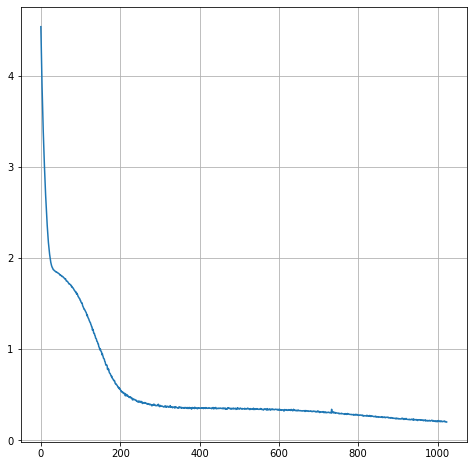

In [411]:
plt.figure(figsize=(8, 8))
plt.plot(Loss[1:])
plt.grid()
plt.show()

### Sensitivity Learning

In [413]:
start = timeit.default_timer()
epochs = 10
Loss_sensibility = []
for i in range(epochs):
    #C_points = tf.constant([[rdm.randrange(-6000, 6000, 1)*0.001] for i in range(N_collocation)])
    Model.network_learn_u(I_points, YI)
    if i % 1 == 0:
        #print((i/10000)*100, '%')
        loss = Model.get_loss_u(I_points, YI).numpy()
        Loss_sensibility.append(loss)
        #print('Loss: ', Model.get_loss(C_points, I_points, B_points, YI, YB).numpy())
    if i%(epochs/5)==0:
        #print((i/epochs)*100, '%')
        print((i/epochs)*100, '%', end='\r')
    print
    

stop = timeit.default_timer()
print('Time: ', stop - start)

Time:  0.30795149999903515


### Plot The Sensitivity Loss

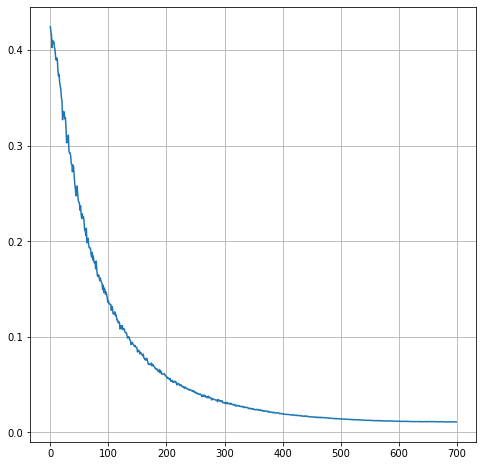

In [328]:
plt.figure(figsize=(8, 8))
plt.plot(Loss_sensibility)
plt.grid()
plt.show()

### Plot

In [380]:
def plot_model(Model, title):
    X = [i*0.01 for i in range(-600,600)]
    Y = []
    for x in X:
        Y.append(Model.run(tf.constant([[x]]))[0])

    fig = plt.figure(figsize=(10, 10))
    plt.plot(X,Y)
    plt.ylim(-2.5,2.5)
    plt.grid()
    plt.show()
    fig.savefig(str(title))

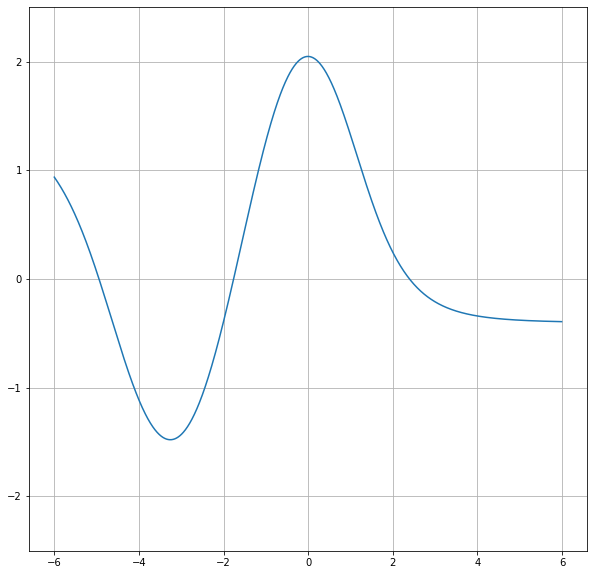

In [414]:
plot_model(Model, "plot5")